# 主要程序

本笔记本整理了本次课题所使用的主要可视化程序以及一些有关主程序的介绍，其中包括：

1. 数据预处理（降维/规范化）                                ---第二章
2. 二分类Dice可视化，观察二分类模型效果收敛情况                ---第三章
3. 同时9中分类的Dice收敛情况                               ---第三章
4. 像素值统计                       —--第四章
5. 知识蒸馏/重采样/加权损失后的Dice（Muscle收敛情况对比）      ---第四章


## 1. 数据预处理 

In [ ]:
# 见单独的notebook

## 2. 二分类模型 

只显示了前35个，可以查看更多

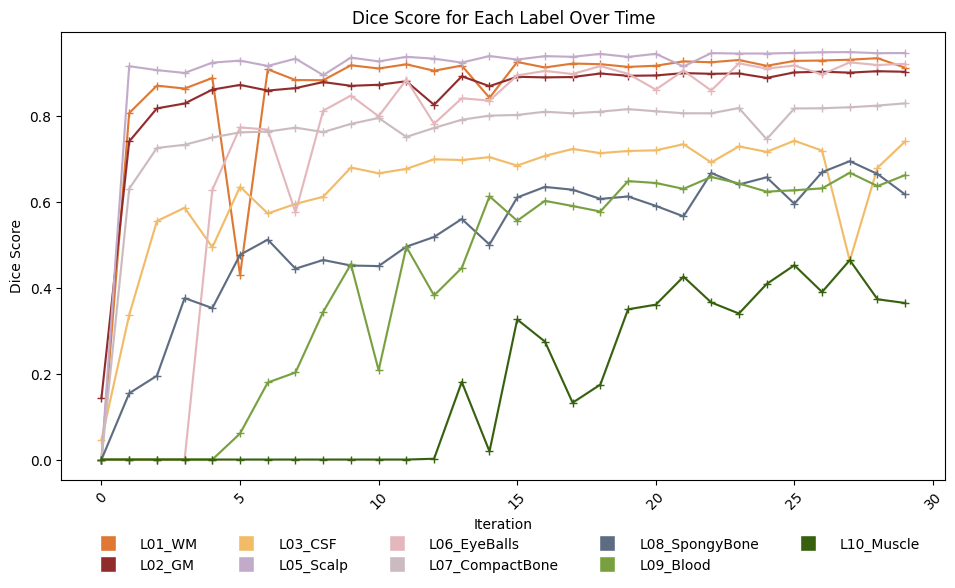

In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # 导入Line2D用于创建自定义图例
# 定义数据文件夹路径
data_folder = '/tmp/code/brain_seg/10_labels/'
# 定义所有的 label 文件夹
all_label_folders = ['L01_WM', 'L02_GM', 'L03_CSF', 'L05_Scalp', 'L06_EyeBalls',
                     'L07_CompactBone', 'L08_SpongyBone', 'L09_Blood', 'L10_Muscle']
# 创建一个图表以可视化每个标签的 Dice 分数
fig, ax = plt.subplots(figsize=(10, 6))  # 调整图的大小以使其更加紧凑
# 定义一组饱和度高的不同颜色
colors = ['#DE7833', '#912C2C', '#F2BB68', '#C2ABC8', '#E4B7BC', '#CBBBC1', '#5E6C82', '#78A040', '#36600E', '#276C9E']
# 用于存储图例元素的列表
legend_elements = []
# 绘制每个标签随时间变化的 Dice 分数
for i, label_folder in enumerate(all_label_folders):
    # 构建.npy文件的路径
    result_file = os.path.join(data_folder, label_folder, 'result', 'prediction_record.npy')
    # 检查文件是否存在
    if not os.path.exists(result_file):
        print(f"Skipping {label_folder} as prediction_record.npy doesn't exist.")
        continue
    # 加载.npy文件
    result_data = np.load(result_file, allow_pickle=True)
    check_names = result_data[:, 0]
    prediction_results = result_data[:, 1].astype(float)  # 将结果转换为浮点数
    # 创建编号（从0到N-1）作为X轴
    x = list(range(len(check_names)))
    # ERROR估计
    error = 0.0  # Define the error range
    upper_bound = prediction_results + error
    lower_bound = prediction_results - error
    # 绘制折线图，使用 '+' 符号连接数据点
    end = 30
    plt.plot(x[:end], prediction_results[:end], linestyle='-', marker='+', color=colors[i % len(colors)], label=label_folder)
    # error带
    plt.fill_between(x[:end], lower_bound[:end], upper_bound[:end], color=colors[i % len(colors)], alpha=0.1)
    # 添加图例元素到列表中
    legend_elements.append(Line2D([0], [0], marker='s', color='w', markersize=12, markerfacecolor=colors[i % len(colors)], lw=2, label=label_folder))
# 设置图的属性
plt.title("Dice Score for Each Label Over Time")
plt.xlabel("Iteration")
plt.ylabel("Dice Score")
plt.xticks(rotation=45)
# legend
legend = ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, handlelength=3)
frame = legend.get_frame()
frame.set_facecolor('none')
frame.set_linewidth(0)
plt.tight_layout()
# 显示图
plt.savefig('2class.png', dpi=600)

plt.show()

## 3. 多分类模型 

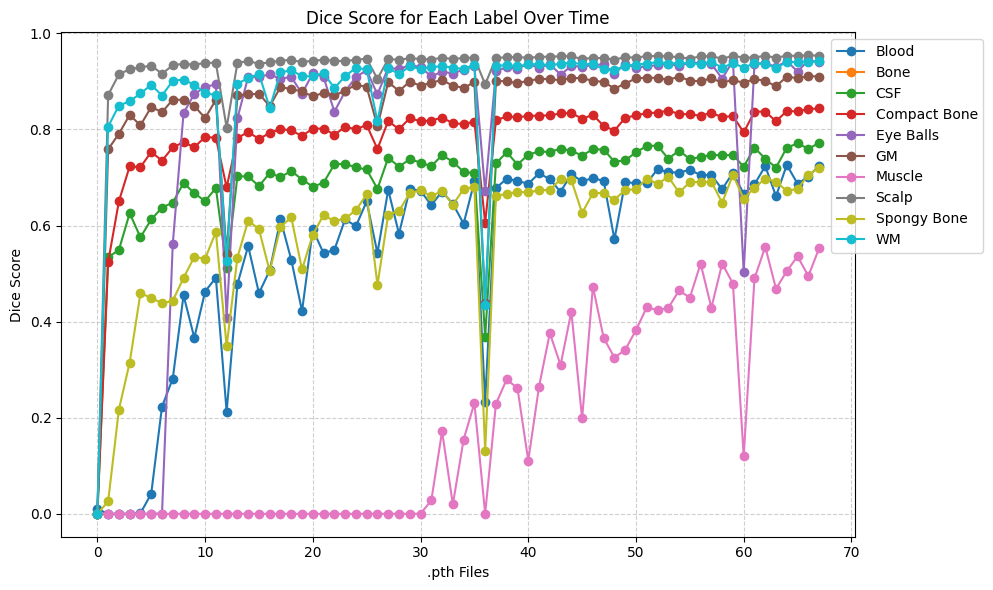

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 指定.npy文件的路径
result_file = file_record = f'/tmp/code/brain_seg/p00/dice/prediction_record.npy'

# 加载.npy文件
result_data = np.load(result_file, allow_pickle=True)
#print(result_data)
# 提取预测结果和文件名
#check_names, prediction_results = zip(*result_data)

# 加载保存的预测结果数据
data = result_data
# 提取唯一的.pth文件名称
unique_checknames = np.unique(data[:, 0])
##改成数字编号
unique_checknames = np.arange(0, len(unique_checknames) + 0)

# 创建一个图表以可视化每个标签的 Dice 分数
plt.figure(figsize=(10, 6))
for label in np.unique(data[:, 1]):
    label_data = data[data[:, 1] == label]
    plt.plot(unique_checknames, label_data[:, 2].astype(float),'-o', label=label)
    #plt.plot(cnt, label_data[:, 2].astype(float), label=label)

plt.xlabel('.pth Files')
plt.ylabel('Dice Score')
plt.title('Dice Score for Each Label Over Time')
plt.xticks(rotation=0)
#plt.legend()
plt.legend(loc='upper right', bbox_to_anchor=(1.17, 1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()


可以加入误差分析

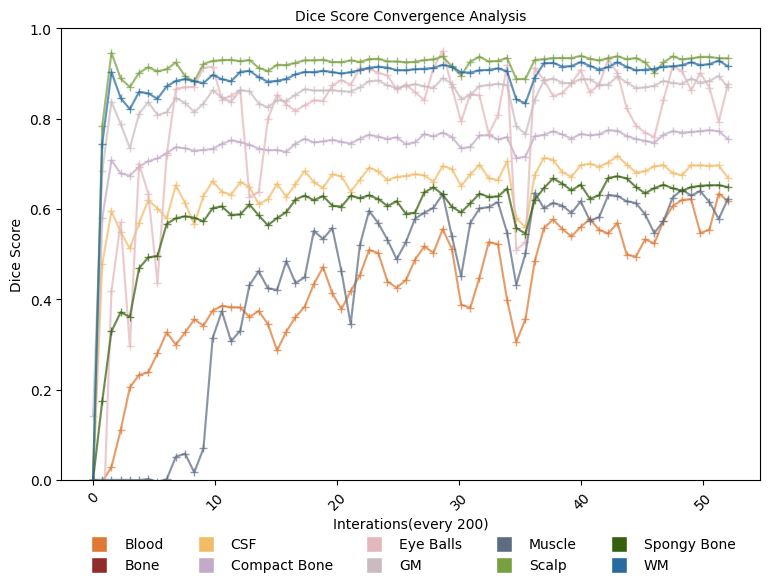

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Load data from .npy file
#result_file = file_record = f'/tmp/code/brain_seg/p00/dice/prediction_record.npy'
result_file = file_record = f'/tmp/code/brain_seg/p00/dice/prediction_record4_28.npy'
result_data = np.load(result_file, allow_pickle=True)

# Extract unique .pth file names
unique_checknames = np.arange(0, len(np.unique(result_data[:, 0])))

# Create a figure for visualization
fig, ax = plt.subplots(figsize=(8, 6))

# Define a set of distinct colors with high saturation
colors = ['#DE7833', '#912C2C', '#F2BB68', '#C2ABC8', '#E4B7BC', '#CBBBC1', '#5E6C82', '#78A040', '#36600E', '#276C9E']  # These colors are more distinguishable
line_styles = ['-+']

# Plot each label's Dice scores over time
for i, label in enumerate(np.unique(result_data[:, 1])):
    label_data = result_data[result_data[:, 1] == label]
    # Filter out NaNs and infs
    valid_indices = np.isfinite(label_data[:, 2].astype(float))
    label_data = label_data[valid_indices]
    if len(label_data) > 0:  # Check if there are valid data points
        # Perform interpolation
        smooth_x = np.linspace(unique_checknames.min(), unique_checknames.max(), 70)
        spl = make_interp_spline(unique_checknames, label_data[:, 2].astype(float), k=3)
        smooth_y = spl(smooth_x)
        # Plot with solid line
        plt.plot(smooth_x, smooth_y, line_styles[i % len(line_styles)], 
                 color=colors[i % len(colors)], alpha=0.7, label=f'Label {label}')
        # Calculate error range
        error = 0.00  # Define the error range
        upper_bound = smooth_y + error
        lower_bound = smooth_y - error
        # Plot the shaded error band
        plt.fill_between(smooth_x, lower_bound, upper_bound, color=colors[i % len(colors)], alpha=0.1)

# Set plot attributes
plt.xlabel('Interations(every 200)', fontsize=10)
plt.ylabel('Dice Score', fontsize=10)
plt.ylim(0, 1)
plt.title('Dice Score Convergence Analysis', fontsize=10)
plt.xticks(rotation=45)

# Customize legend
legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[i], markersize=12, label=f'{label}') for i, label in enumerate(np.unique(result_data[:, 1]))]
legend = ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, handlelength=2)  # Adjust the handlelength to make legend more compact
frame = legend.get_frame()
frame.set_facecolor('none')
frame.set_linewidth(0)

plt.tight_layout()

# Show plot
plt.savefig('9class.png', dpi=600)
plt.show()

## 4. 像素值统计，分析dataset等

4.1 观察少数类别特征

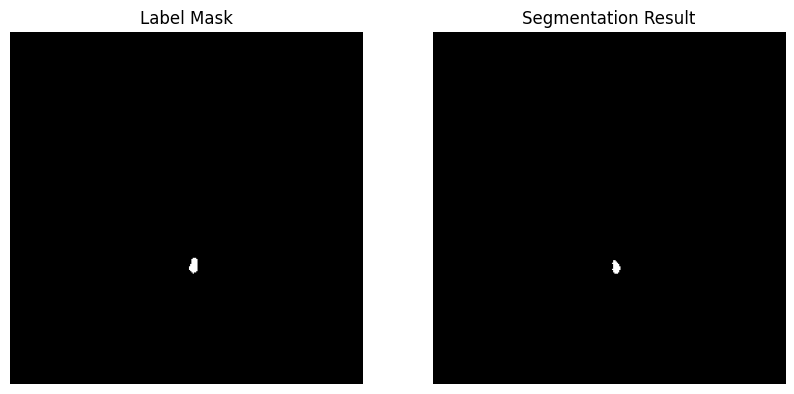

In [15]:
##观察结构病灶形态
import numpy as np
import matplotlib.pyplot as plt

# Load the array from the .npy file
array0 = np.load('/tmp/code/brain_seg/data00/test/00/QJSH012.npy')
array1 = np.load('/tmp/code/brain_seg/p00/segmentation_result/QJSH012.npy_0_4444_0_0.0001_10_0426_20:43:40.pth.npy')

# Set all non-10 values in array0 to 0
array0[array0 != 10] = 0

# Set all non-10 values in array1 to 0
array1[array1 != 10] = 0

# Choose a slice to visualize (for example, the middle slice along the first dimension)
slice_index = array0.shape[1] // 2
slice_index = 60
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 10))

# Plot the slices
#im0 = axs[0].imshow(array0[0, slice_index, :, :], cmap='gray')
#axs[0].set_title('MRI Scan')
#axs[0].axis('off')  # Turn off axis for cleaner visualization

im1 = axs[0].imshow(array0[1, slice_index, :, :], cmap='gray')
axs[0].set_title('Label Mask')
axs[0].axis('off')

im2 = axs[1].imshow(array1[slice_index, :, :], cmap='gray')
axs[1].set_title('Segmentation Result')
axs[1].axis('off')

# Create a colorbar using a dummy image
#cbar = fig.colorbar(im0, ax=axs, orientation='vertical')
#cbar.set_label('Intensity')

plt.show()

4.2 pixel统计

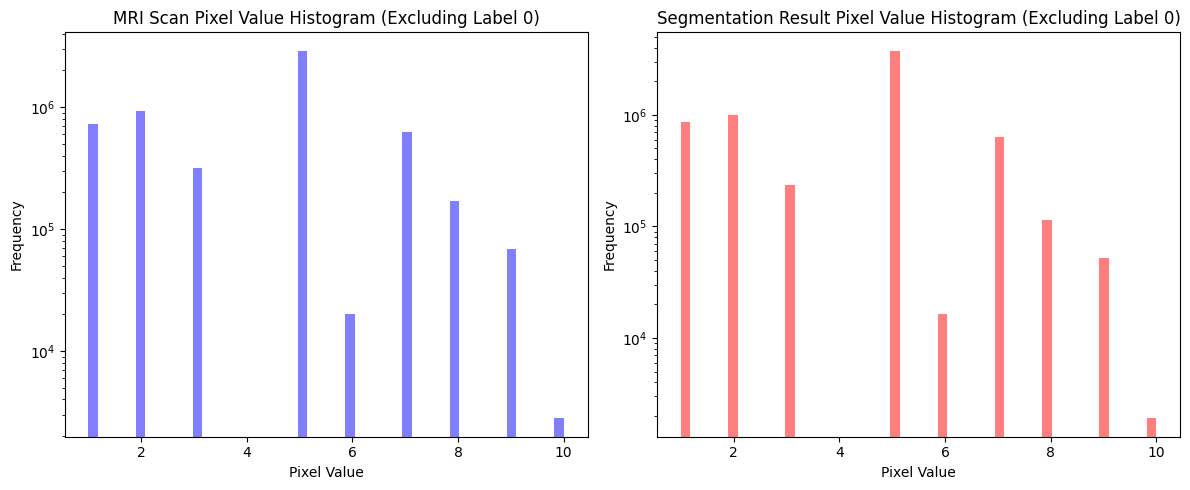

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# load数据，本地
array0 = np.load('/tmp/code/brain_seg/data00/test/00/QJSH032.npy')
array1 = np.load('/tmp/code/brain_seg/p00/segmentation_result/QJSH034.npy_0_4444_0_0.0001_10_0417_14:51:22.pth.npy')

# Filter out label 0 pixels
mask0 = array0[1] != 0
mask1 = array1 != 0
filtered_array0 = array0[1][mask0].flatten()
filtered_array1 = array1[mask1].flatten()

# Plot histograms of pixel values
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram of MRI scan
axs[0].hist(filtered_array0, bins=50, color='blue', alpha=0.5)
axs[0].set_title('MRI Scan Pixel Value Histogram (Excluding Label 0)')
axs[0].set_xlabel('Pixel Value')
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log')  # Set y-axis to log scale

# Plot histogram of segmentation result
axs[1].hist(filtered_array1, bins=50, color='red', alpha=0.5)
axs[1].set_title('Segmentation Result Pixel Value Histogram (Excluding Label 0)')
axs[1].set_xlabel('Pixel Value')
axs[1].set_ylabel('Frequency')
axs[1].set_yscale('log')  # Set y-axis to log scale

plt.tight_layout()
plt.show()

## 5. 优化后

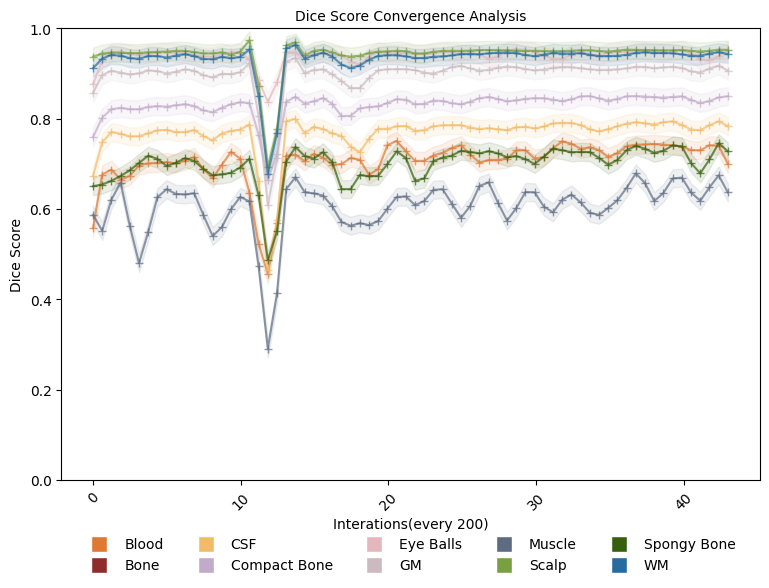

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# Load data from .npy file
#result_file = file_record = f'/tmp/code/brain_seg/p00/dice/prediction_record4_28.npy'
#result_file = file_record = f'/tmp/code/brain_seg/p00/dice/prediction_record_kdw.npy'

result_data = np.load(result_file, allow_pickle=True)

# Extract unique .pth file names
unique_checknames = np.arange(0, len(np.unique(result_data[:, 0])))

# Create a figure for visualization
fig, ax = plt.subplots(figsize=(8, 6))

# Define a set of distinct colors with high saturation
colors = ['#DE7833', '#912C2C', '#F2BB68', '#C2ABC8', '#E4B7BC', '#CBBBC1', '#5E6C82', '#78A040', '#36600E', '#276C9E']  # These colors are more distinguishable
line_styles = ['-+']

# Plot each label's Dice scores over time
for i, label in enumerate(np.unique(result_data[:, 1])):
    label_data = result_data[result_data[:, 1] == label]
    #print(label_data)
    # Filter out NaNs and infs
    valid_indices = np.isfinite(label_data[:, 2].astype(float))
    label_data = label_data[valid_indices]
    if len(label_data) > 0:  # Check if there are valid data points
        # Perform interpolation
        smooth_x = np.linspace(unique_checknames.min(), unique_checknames.max(), 70)
        spl = make_interp_spline(unique_checknames, label_data[:, 2].astype(float), k=3)
        smooth_y = spl(smooth_x)
        # Plot with solid line
        plt.plot(smooth_x, smooth_y, line_styles[i % len(line_styles)], 
                 color=colors[i % len(colors)], alpha=0.7, label=f'Label {label}')
        # Calculate error range
        error = 0.02  # Define the error range
        upper_bound = smooth_y + error
        lower_bound = smooth_y - error
        # Plot the shaded error band
        plt.fill_between(smooth_x, lower_bound, upper_bound, color=colors[i % len(colors)], alpha=0.1)

# Set plot attributes
plt.xlabel('Interations(every 200)', fontsize=10)
plt.ylabel('Dice Score', fontsize=10)
plt.ylim(0, 1)
plt.title('Dice Score Convergence Analysis', fontsize=10)
plt.xticks(rotation=45)

# Customize legend
legend_elements = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=colors[i], markersize=12, label=f'{label}') for i, label in enumerate(np.unique(result_data[:, 1]))]
legend = ax.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=5, handlelength=2)  # Adjust the handlelength to make legend more compact
frame = legend.get_frame()
frame.set_facecolor('none')
frame.set_linewidth(0)

plt.tight_layout()

# Show plot
plt.show()

muscle的收敛变化

可视化分割结果

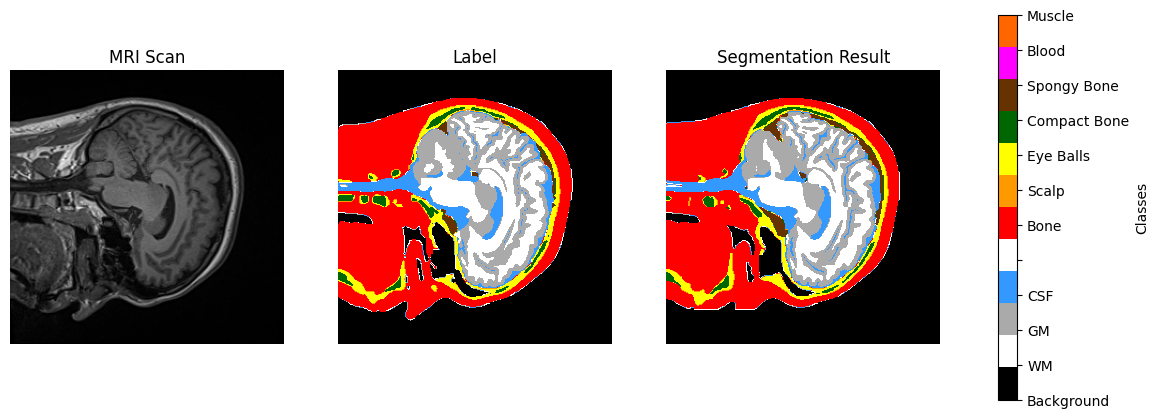

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

# Load the arrays from the .npy files

array0 = np.load('/tmp/code/brain_seg/data00/test/0010/QJGZ029.npy')
#array1 = np.load('/tmp/code/brain_seg/p00/segmentation_result/QJGZ029.npy_0_4444_0_0.0001_10_0426_20:43:40.pth.npy')
array1 = np.load('/tmp/code/brain_seg/p00/segmentation_result/QJGZ029.npy_0_4444_0_0.0001_10_0427_15:51:58.pth.npy')


# Define label list
label_list = ['Background', 'WM', 'GM', 'CSF', None, 'Bone', 'Scalp', 'Eye Balls', 'Compact Bone', 'Spongy Bone', 'Blood', 'Muscle']

# Define colors for each label
label_colors = ['#000000',  # Background
                '#FFFFFF',  # WM (White Matter)
                '#AAAAAA',  # GM (Gray Matter)
                '#3399FF',  # CSF (Cerebrospinal Fluid)
                '#FFFFFF',  # None (Transparent)
                '#FF0000',  # Bone
                '#FF9900',  # Scalp
                '#FFFF00',  # Eye Balls
                '#006600',  # Compact Bone
                '#663300',  # Spongy Bone
                '#FF00FF',  # Blood
                '#FF6600']  # Muscle

# Choose a slice to visualize (for example, the middle slice along the first dimension)
slice_index = array0.shape[1] // 2
slice_index = 80

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot the slices
im0 = axs[0].imshow(array0[0, slice_index, :, :], cmap='gray')
axs[0].set_title('MRI Scan')
axs[0].axis('off')  # Turn off axis for cleaner visualization

# Create a custom colormap for segmentation result
cmap = matplotlib.colors.ListedColormap(label_colors)

im1 = axs[1].imshow(array0[1, slice_index, :, :], cmap=cmap, vmin=0, vmax=len(label_list)-1)
axs[1].set_title('Label')
axs[1].axis('off')

im2 = axs[2].imshow(array1[slice_index, :, :], cmap=cmap, vmin=0, vmax=len(label_list)-1)
axs[2].set_title('Segmentation Result')
axs[2].axis('off')

# Add legend for segmentation result
cbar = fig.colorbar(im2, ax=axs, orientation='vertical', ticks=np.arange(len(label_list)))
cbar.set_label('Classes')
cbar.ax.set_yticklabels(label_list)

plt.show()
plt.savefig('seg_r.png', dpi=600)

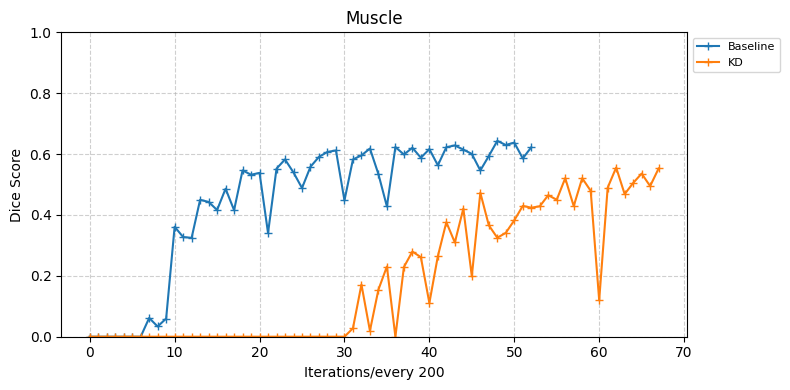

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 指定两个.npy文件的路径
file1 = '/tmp/code/brain_seg/p00/dice/prediction_record4_28.npy'
file2 = '/tmp/code/brain_seg/p00/dice/prediction_record.npy'

# 加载.npy文件
result_data1 = np.load(file1, allow_pickle=True)
result_data2 = np.load(file2, allow_pickle=True)

# 提取唯一的.pth文件名称
unique_checknames1 = np.unique(result_data1[:, 0])
unique_checknames2 = np.unique(result_data2[:, 0])

# 提取特定标签的数据
#selected_label = "Compact Bone"
#selected_label = "Spongy Bone"
#selected_label = "Blood"
#selected_label = "Eye Balls"
#selected_label = "CSF"
#selected_label = "Scalp"
#selected_label = "WM"
#selected_label = "GM"
selected_label = "Muscle"

# 从第一个文件中提取标签为 "muscle" 的数据
label_data1 = result_data1[result_data1[:, 1] == selected_label]
# 从第二个文件中提取标签为 "muscle" 的数据
label_data2 = result_data2[result_data2[:, 1] == selected_label]

# 创建图表以可视化两个文件中 "muscle" 标签的 Dice 分数对比
plt.figure(figsize=(8, 4))

# 统一两个文件的横轴
end = 90
x1 = np.arange(0, len(label_data1[:end]))
x2 = np.arange(0, len(label_data2[:end]))

plt.plot(x1, label_data1[:end, 2].astype(float), '-+', label='Baseline')
plt.plot(x2, label_data2[:end, 2].astype(float), '-+', label='KD')


plt.ylim(0,1)
plt.xlabel('Iterations/every 200')
plt.ylabel('Dice Score')
plt.title(f'{selected_label}')
plt.xticks(rotation=0)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', prop={'size': 8})  # 将图例放置在右上角
plt.tight_layout()
plt.savefig('4-3.png', dpi=600)
plt.show()

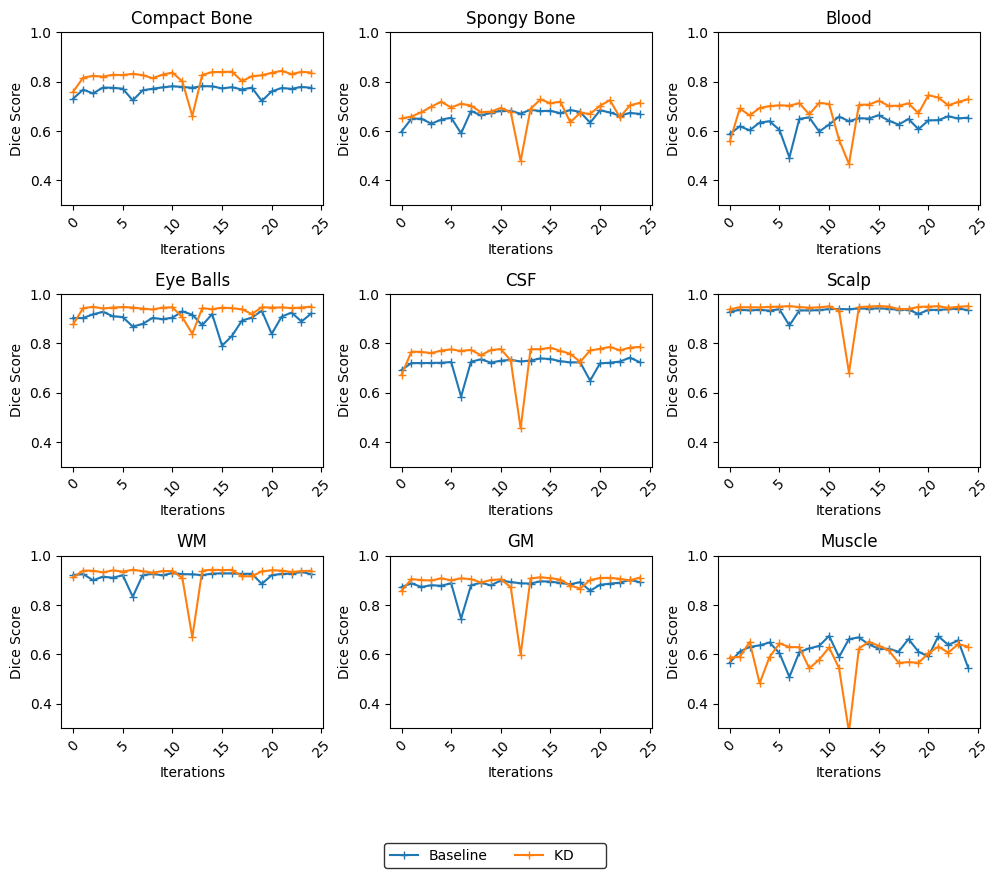

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# 指定两个.npy文件的路径
file1 = '/tmp/code/brain_seg/p00/dice/prediction_record_w.npy'
file2 = '/tmp/code/brain_seg/p00/dice/prediction_record_kdw.npy'

# 加载.npy文件
result_data1 = np.load(file1, allow_pickle=True)
result_data2 = np.load(file2, allow_pickle=True)

# 提取唯一的.pth文件名称
unique_checknames1 = np.unique(result_data1[:, 0])
unique_checknames2 = np.unique(result_data2[:, 0])

# 需要比较的标签列表
selected_labels = ["Compact Bone", "Spongy Bone", "Blood", "Eye Balls", "CSF", "Scalp", "WM", "GM", "Muscle"]

# 创建一个大图和子图数组
fig, axs = plt.subplots(3, 3, figsize=(10, 8))

# 遍历每个标签
for index, selected_label in enumerate(selected_labels):
    # 从第一个文件中提取特定标签的数据
    label_data1 = result_data1[result_data1[:, 1] == selected_label]
    # 从第二个文件中提取特定标签的数据
    label_data2 = result_data2[result_data2[:, 1] == selected_label]

    # 统一两个文件的横轴
    end = 25
    x1 = np.arange(0, len(label_data1[:end]))
    x2 = np.arange(0, len(label_data2[:end]))

    # 在大图中添加子图
    row = index // 3
    col = index % 3
    ax = axs[row, col]
    ax.plot(x1, label_data1[:end, 2].astype(float), '-+', label='Baseline')
    ax.plot(x2, label_data2[:end, 2].astype(float), '-+', label='KD      ')

    ax.set_ylim(0.3, 1)
    ax.set_xlabel('Iterations')
    ax.set_ylabel('Dice Score')
    ax.set_title(f'{selected_label}')
    ax.tick_params(axis='x', rotation=45)
    # ax.legend(prop={'size': 8})  # 不在每个子图中添加图例


# 添加统一的图例
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, fontsize='medium', fancybox=True, edgecolor='black', bbox_to_anchor=(0.5,-0.1))  # 设置图例的位置、大小和样式
# 调整子图布局
plt.tight_layout()
plt.show()
